# Travel Website Recommendation System: A/B Testing
A new feature is being tested on a website, and the company wants to understand the downstream effects on revenue due to this feature addition. This feature corresponds to a new offering to customers/users, that the company doesn't want to offer yet. Hence a direct A/B test would not work. This notebook looks at libraries DoWhy and EconML to build a causal model and understand this area better. 

![Travel Website](Images/philipp-kammerer-6Mxb_mZ_Q8E-unsplash.jpg)

The company in question is a travel website, and they would like to know if joining their membership program would increase website engagement and increase in product purchases. 

Conducting a straightforward A/B test is impractical as the website lacks the capability to compel users into membership. Similarly, the travel company cannot directly analyze existing data by contrasting members and non-members, since those who opt for membership are probably already more actively involved compared to other users.

The solution presents itself through an earlier experiment by the company: Previously, the company had conducted a trial to assess the efficacy of a quicker registration procedure. This experimental nudge towards membership can be used to generate random variation in the likelihood of membership, using a particular class of estimators called Instrument Variable (IV) estimators. IV estimators work by assigning causal relationships to the independent variable using 'a proxy', or an instrument variable. This nudge is called an $intent-to-treat$ setting: the intention is to give a random group of users the "treatment" (access to the easier sign-up process), but not all users will actually take it.

In [1]:
!pip install dowhy lightgbm networkx econml numpy==1.25 

In [2]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# DoWhy imports 
import dowhy
from dowhy import CausalModel

In [6]:
# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

### Data 
The data has been synthetically generated (feature distributions do not correspond to actual distributions) in the 28 days prior to and post the experiment. However, the feature names have preserved the names and meanings. 

The data consists of: 
- features collected 28 days prior to the experiment (denoted by suffix '_pre')
- experiment variables (whether the user was exposed to the easier signup -> the instrument, and whether the user became a member -> the treatment)
- features collected in the 28 days after the experiment (denoted by the suffix _post)


| Feature Name | Description |
| ----------- | ----------- |
| days_visited_exp_pre | # of days a user visits the attractions pages |
| days_visited_free_pre | # days a user visits the website through free channels (e.g. domain direct) |
| days_visited_fs_pre | # days a user visits the flights pages |
| days_visited_hs_pre | # days a user visits the hotels pages |
| days_visited_rs_pre | # days a user visits the restaurants pages |
| days_visited_vrs_pre | # days a user visits the vacation rental pages |
| locale_en_US | whether the user access the website from the US |
| os_type | user's operating system (windows, osx, other) |
| revenue_pre | how much the user spent on the website in the pre-period |
| easier_signup | whether the user was exposed to the easier signup process |
| became_member | whether the user became a member |
| days_visited_post | # days a user visits the website in the 28 days after the experiment |

In [7]:
# Import the sample AB data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [11]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [15]:
# Defining estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

The following equation was used to generate the outcome variable: 
> *treatment_effect = 0.2 + 0.3 * days_visited_free_pre - 0.2 * days_visited_hs_pre + os_type_osx*

In essence, users who visited the website before the experiment and/or who use an iPhone tended to benefit from the membership program and showed up more often after the experiment; whereas users who visited the hotels pages tended to be harmed by membership. **This is the relationship we seek to learn from the data.**

In [16]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(X_data)

In [28]:
X_data.columns

Index(['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows'],
      dtype='object')

In [29]:
# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

In [30]:
true_coefs

array([ 0. ,  0.3,  0. , -0.2,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ])

### Creating a Causal Model and Identifying Causal Effect

In [31]:
feature_names = X_data.columns.to_list()
feature_names

['days_visited_exp_pre',
 'days_visited_free_pre',
 'days_visited_fs_pre',
 'days_visited_hs_pre',
 'days_visited_rs_pre',
 'days_visited_vrs_pre',
 'locale_en_US',
 'revenue_pre',
 'os_type_osx',
 'os_type_windows']

In [32]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

Here we are defining the current relationships; the fact that the user became a member (T) is a result of the activity before the experiment (X) and the easier signup process (Z). The other model is the days visited post the experiment (Y) is a direct result of the activity before the experiment (X). The flexible model is used for estimating other non-linear or flexible effects related to the outcome Y given X. 

In [33]:
# initiate an EconML cate estimator
est = LinearIntentToTreatDRIV(model_t_xwz=model_T_XZ, model_y_xw=model_Y_X,
                            flexible_model_effect=flexible_model_effect,
                            featurizer=PolynomialFeatures(degree=1, include_bias=False))

Here, we define the Conditional Average Treatment Effect (CATE) estimator using the EconML library. The CATE estimator is used to estimate the average treatment effect for individuals with specific characteristics or covariates (X). In this case, our CATE model is called Linear Intent to Treat using Double/Debiased Machine Learning and Instrument Variables. The featurizer is specifying that first-order featurization is being applied to covariates.  Double ML estimates nuisance parameters (e.g., treatment and outcome models) using various models (LGBMClassifier and LGBMRegressor, respectively, in our case), and corrects for bias using cross-fitting. Debiased ML further adjusts for potential biases introduced by instrumental variables.

The reason why a CATE estimator is used is to minimize or eliminate endogeneity and confounding factors associated with the IV ('easier_signup). In the field of causal inference, these terms mean the following:
- **Endogeneity**: This happens when the treatment variable (for example, 'became_member') is connected to hidden factors that affect the outcome ('days_visited_post'). These hidden factors are not included in the analysis, leading to biased results. The CATE estimator addresses endogeneity by considering these hidden factors and their potential impact on the treatment's effect on the outcome.
- **Confounding**: This occurs when other variables influence both the treatment and the outcome. These variables can create a false impression of a direct relationship between the treatment and the outcome. The CATE estimator deals with confounding by untangling the influence of these other variables, allowing for a more accurate understanding of the true impact of the treatment on the outcome.

In [34]:
# fit through dowhy
test_customers = X_data.iloc[:1000]
est_dw=est.dowhy.fit(Y, T, Z=Z, X=X_data, outcome_names=["days_visited_post"], treatment_names=["became_member"],
                     feature_names=feature_names, instrument_names=["easier_signup"], target_units=test_customers,
                     inference="statsmodels")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 66666, number of used features: 20
[LightGBM] [Info] Start training from score 9.967615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [37]:
type(est_dw)

econml.dowhy.DoWhyWrapper

<Figure size 1000x800 with 0 Axes>

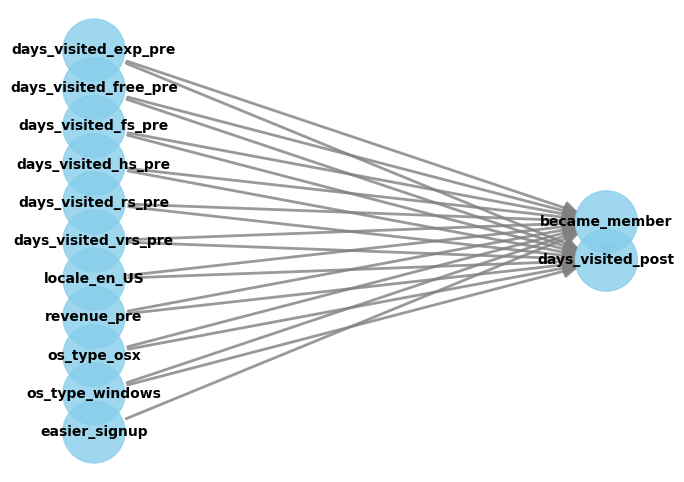

In [40]:
# Visualize causal graph
plt.figure(figsize=(10,8))
est_dw.view_model(layout=None) 

In [41]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(E[days_visited_post|locale_en_US,days_visited_hs_pre,days_vis
d[became_member]                                                              

                                                                              
ited_free_pre,os_type_osx,days_visited_fs_pre,revenue_pre,days_visited_rs_pre,
                                                                              

                                                           
days_visited_vrs_pre,days_visited_exp_pre,os_type_windows])
                                                           
Estimand assumption 1, Unconfoundedness: If U→{became_member} and U→days_visited_post then P(days_visited_post|became_member,locale_en_US,days_visited_hs_pre,days_visited_free_pre,os_type_osx,days_visited_fs_pre,revenue_pre,days_visite

All information has been derived and modified for learning purposes from [EconML Use Cases](https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Recommendation%20AB%20Testing%20at%20An%20Online%20Travel%20Company%20-%20EconML%20+%20DoWhy.ipynb)